*Initially created at 03.01.2018 by Petteri Nevavuori (<petteri.nevavuori@mtech.fi>)*

---

# GDAL IV. Dataset DB Creation

In this notebook we will go through the process of creating DB rows for each area. This is to avoid a seriously cluttered multi-level folder jungle, where there exists hundreds of area wise time series per field block for distinct dates. A lot of the information would have to be encoded in the filenames, wherefore it was deemed best to build a simple DB for block area row persistence.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#1.-Introduction" data-toc-modified-id="1.-Introduction-1">1. Introduction</a></span></li><li><span><a href="#2.-Generating-Areas-and-DataPeriods-to-DB" data-toc-modified-id="2.-Generating-Areas-and-DataPeriods-to-DB-2">2. Generating Areas and DataPeriods to DB</a></span><ul class="toc-item"><li><span><a href="#2.1-Pre-fetch-CSV-data" data-toc-modified-id="2.1-Pre-fetch-CSV-data-2.1">2.1 Pre-fetch CSV data</a></span><ul class="toc-item"><li><span><a href="#2.1.1-Soil-data" data-toc-modified-id="2.1.1-Soil-data-2.1.1">2.1.1 Soil data</a></span></li><li><span><a href="#2.1.2-Weather-data" data-toc-modified-id="2.1.2-Weather-data-2.1.2">2.1.2 Weather data</a></span></li></ul></li><li><span><a href="#2.2-Shapefiles-to-area-grids" data-toc-modified-id="2.2-Shapefiles-to-area-grids-2.2">2.2 Shapefiles to area grids</a></span></li><li><span><a href="#2.3-Date-wise-dataset-generation" data-toc-modified-id="2.3-Date-wise-dataset-generation-2.3">2.3 Date wise dataset generation</a></span><ul class="toc-item"><li><span><a href="#2.3.1-Areas" data-toc-modified-id="2.3.1-Areas-2.3.1">2.3.1 Areas</a></span></li><li><span><a href="#2.3.2-DataPeriods" data-toc-modified-id="2.3.2-DataPeriods-2.3.2">2.3.2 DataPeriods</a></span></li><li><span><a href="#2.3.3-Targets" data-toc-modified-id="2.3.3-Targets-2.3.3">2.3.3 Targets</a></span></li></ul></li><li><span><a href="#2.4-Projection-window-of-20m" data-toc-modified-id="2.4-Projection-window-of-20m-2.4">2.4 Projection window of 20m</a></span></li><li><span><a href="#2.5-Projection-window-of-40m" data-toc-modified-id="2.5-Projection-window-of-40m-2.5">2.5 Projection window of 40m</a></span></li></ul></li><li><span><a href="#3.-Selecting-Test-samples" data-toc-modified-id="3.-Selecting-Test-samples-3">3. Selecting Test samples</a></span><ul class="toc-item"><li><span><a href="#3.1-Creating-the-fields" data-toc-modified-id="3.1-Creating-the-fields-3.1">3.1 Creating the fields</a></span></li><li><span><a href="#3.2-Labeling-the-samples" data-toc-modified-id="3.2-Labeling-the-samples-3.2">3.2 Labeling the samples</a></span></li></ul></li><li><span><a href="#4.-Generated-dataset-content-overview" data-toc-modified-id="4.-Generated-dataset-content-overview-4">4. Generated dataset content overview</a></span><ul class="toc-item"><li><span><a href="#4.1-DB-entries'-overview" data-toc-modified-id="4.1-DB-entries'-overview-4.1">4.1 DB entries' overview</a></span></li><li><span><a href="#4.2-Sample-Area-examination" data-toc-modified-id="4.2-Sample-Area-examination-4.2">4.2 Sample Area examination</a></span></li><li><span><a href="#4.3-Sample-Area's-DataPeriods" data-toc-modified-id="4.3-Sample-Area's-DataPeriods-4.3">4.3 Sample Area's DataPeriods</a></span></li><li><span><a href="#4.4-Sample-Area's-Target" data-toc-modified-id="4.4-Sample-Area's-Target-4.4">4.4 Sample Area's Target</a></span></li><li><span><a href="#4.6-Multiple-targets" data-toc-modified-id="4.6-Multiple-targets-4.5">4.6 Multiple targets</a></span></li><li><span><a href="#4.7-RGB-NDVI-pairs" data-toc-modified-id="4.7-RGB-NDVI-pairs-4.6">4.7 RGB-NDVI pairs</a></span></li><li><span><a href="#4.8-Target-value-distributions" data-toc-modified-id="4.8-Target-value-distributions-4.7">4.8 Target value distributions</a></span></li><li><span><a href="#4.9-Input-target-pairs" data-toc-modified-id="4.9-Input-target-pairs-4.8">4.9 Input-target pairs</a></span></li><li><span><a href="#4.10-Field-wise-and-date-wise-statistics" data-toc-modified-id="4.10-Field-wise-and-date-wise-statistics-4.9">4.10 Field-wise and date-wise statistics</a></span></li></ul></li><li><span><a href="#5.-Troubleshooting" data-toc-modified-id="5.-Troubleshooting-5">5. Troubleshooting</a></span><ul class="toc-item"><li><span><a href="#5.1-Black-RGB-images---Resolved" data-toc-modified-id="5.1-Black-RGB-images---Resolved-5.1">5.1 Black RGB images - Resolved</a></span></li><li><span><a href="#5.2-Yellow-Blocks---Resolved" data-toc-modified-id="5.2-Yellow-Blocks---Resolved-5.2">5.2 Yellow Blocks - Resolved</a></span></li><li><span><a href="#5.3-Purple-blocks---No-action" data-toc-modified-id="5.3-Purple-blocks---No-action-5.3">5.3 Purple blocks - No action</a></span></li><li><span><a href="#5.4-Drop-of-incorrect-field---Resolved" data-toc-modified-id="5.4-Drop-of-incorrect-field---Resolved-5.4">5.4 Drop of incorrect field - Resolved</a></span></li></ul></li></ul></div>

## 1. Introduction
  
For each area there are some required data to be stored to ensure using matching areas with datasets varying temporally. We will persist information about the original field block and the area's bounding box corners to a distinct table. The source data that will be used as the input for the training is then persisted to another table with a many-to-one relation to the area table. This is to model the relation properly, where a single area is the same regardless of the time period, but the datasets are inherently date-bound with time series data. The last table will then have the target data for an area with an one-to-one relationship to the area table. The DB model is given below.

The DB population with block and date wise areas follows a process depicted below. The idea is to traverse through temporally distinct datasets for each field block and extract area wise information. An important part in the process is allowing `None` entries for data columns, as not all forms of data is available for each date. 

Another important aspect of the process is that the data forms are indeed numerous. The data forms and their use sources are:

 - *Satellite*, *Drone* and *Nsensor* 
     - Prepared in the field-wise extraction step to year, granule and block corresponding folder structure.
 - *Weather* 
     - Retrieved from Finnish Meteorological Institute's (FMI) API with a script.
 - *Soil* 
     - Extracted from a CSV provided by ProAgria.

## 2. Generating Areas and DataPeriods to DB

To allow for broader research, we will generate additional datasets for multiple image sizes. While it wasn't clear in the previous parts, the areas actually generated with a sliding window. This allows for greater image dimanesions without sacrificing too much from the dataset size. We thus start with 10 m projection window and handle 20 m and 40 m windows after that.

First we initialize the builder.

In [1]:
from field_analysis.db.dataset import DatasetBuilder

builder = DatasetBuilder(initialize=True, area_size_meters=10, area_size_px=32)

### 2.1 Pre-fetch CSV data

Then we will fetch weather and soil datasets to properly usable `DataFrame` objects. We will also perform day wise aggregation of weather data and select the proper statistic accordingly as not every statistic is however usable with every distinct measured feature. Sum is the best measure for precipitation, while mean is a good measure for temperature.

The imported datasets are persisted to the `DatasetBuilder` instance as properties and are thus accessed directly from within the class.

#### 2.1.1 Soil data

In [2]:
builder.get_soil_data().head()

Reading Soil data.. OK


,soil_type_cat,soil_earthiness_cat,soil_conductivity,soil_acidity,soil_calcium,soil_phosphorus,soil_potassium,soil_magnesium,soil_sulphur,soil_copper,soil_manganese,soil_zinc,soil_cec,soil_cec_ca,soil_cec_k,soil_cec_mg,soil_cec_na
block_id,,,,,,,,,,,,,,,,,
9880016135,HeS,rm,1.1,6.6,2400,12.0,270,270,12.3,5.4,17.0,2.7,17,70,4,13,2
9880016034,HeS,rm,1.4,6.6,2000,18.0,250,330,10.3,3.6,35.0,4.5,15,65,4,18,2
9880167291,HeS,erm,1.5,6.1,2800,7.0,230,260,21.4,7.8,10.0,4.0,21,67,3,10,1
9880217714,HeS,erm,1.3,5.8,2500,11.0,250,250,13.0,7.8,31.0,7.6,22,58,3,10,1
6090161366,KHt,m,0.9,6.2,1300,10.0,80,100,24.2,5.9,7.2,1.8,9,69,2,9,3


#### 2.1.2 Weather data

In [3]:
builder.get_weather_data().head()

Reading Weather data.. OK


Air temperature                 Cloud amount                 \
                      mean median      sum         mean median     sum   
Date                                                                     
2017-06-01       10.955313   10.4  11032.0     2.750745    0.0  2770.0   
2017-06-08       13.887885   13.8  13985.1     4.659384    7.0  4692.0   
2017-06-15       14.755655   14.3  14873.7     2.952381    1.0  2976.0   
2017-06-22       11.989087   12.2  12085.0     4.350198    6.0  4385.0   
2017-06-29       16.339087   15.4  16469.8     4.054563    5.0  4087.0   

           Dew-point temperature                Gust speed   ...    \
                            mean median     sum       mean   ...     
Date                                                         ...     
2017-06-01              3.700298   2.10  3726.2   6.157994   ...     
2017-06-08              9.502483  10.20  9569.0   3.937674   ...     
2017-06-15              8.535813   8.25  8604.1   5.240873   ...     
2017-06-22              7.417560   7.60  7476.9   6.171925   ...     
2017-06-29              9.044742   8.40  9117.1   5.245933   ...     

           Relative humidity Snow depth                Wind direction         \
                         sum       mean median     sum           mean median   
Date                                                                           
2017-06-01           65047.0   0.000000    0.0     0.0     233.244290  248.0   
2017-06-08           77862.0  -0.398278    0.0  -370.0     211.997018  224.5   
2017-06-15           68871.0  -1.000000   -1.0 -1008.0     240.382937  267.0   
2017-06-22           75153.0  -1.000000   -1.0 -1000.0     249.179563  282.0   
2017-06-29           66195.0  -1.000000   -1.0  -817.0     171.669643  133.0   

                     Wind speed                 
                 sum       mean median     sum  
Date                                            
2017-06-01  234877.0   3.597517   3.20  3622.7  
2017-06-08  213269.0   2.295527   2.25  2309.3  
2017-06-15  242306.0   3.024306   2.80  3048.5  
2017-06-22  251173.0   3.572321   3.50  3600.9  
2017-06-29  173043.0   2.798810   2.50  2821.2  

[5 rows x 39 columns]

### 2.2 Shapefiles to area grids

Here we'll perform the division of field blocks to grids with a distinct area size. The reason for performing the step here is that the image rasters are most easily divided to grids with shapefiles. We will perform this gridification to the defined set of field blocks, as the original shapefile contains information about Finland's every field for the year 2017.

Effectively we will compute the grid's areas' bounding box corners by traversing the field in blocks of i.e. 10 x 10 m. A simplified visualization of the grid for a single area is as follows. After the corners have been persisted, we will take the next are in the row until the row is exhausted. Then we take the next row and iterate until no areas are left.

    (x,y) +10      +10
    top_corner--+------
    |           |
    |-10        |
    |           |
    +-------bot_corner-
    |           |
    
For each area we will check if the center point of the area falls within the shape of the field block. If it does, we will keep it and discard it otherwise.

A note about the calculations related to ``area_rows`` and ``area_cols`` is in place though. The GDAL used to perform the initial (and subsequential) GeoTiff manipulations *seems* to use rounding with shapefile points. As an example, if the bounding box for the field would be ``148 m`` in widht and ``121 m`` in width, the output of resampling to the resolution of ``10 m/px`` would be an image of resolution ``15 x 12 px``.

Extracting Area grids..
6090006368 centroid=(224847, 6830937)
	x_delta=148.0	y_delta=122.0
	area_cols=15	area_rows=12
	total_areas=180	valid_areas=119


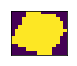

6090006469 centroid=(224658, 6831017)
	x_delta=291.0	y_delta=198.0
	area_cols=29	area_rows=20
	total_areas=580	valid_areas=238


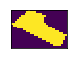

6090161265 centroid=(227622, 6827402)
	x_delta=289.0	y_delta=283.0
	area_cols=29	area_rows=28
	total_areas=812	valid_areas=717


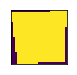

6090161366 centroid=(227632, 6827118)
	x_delta=243.0	y_delta=307.0
	area_cols=24	area_rows=31
	total_areas=744	valid_areas=594


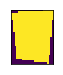

6090205523 centroid=(228685, 6831478)
	x_delta=324.0	y_delta=244.0
	area_cols=32	area_rows=24
	total_areas=768	valid_areas=377


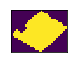

6090324751 centroid=(224262, 6831332)
	x_delta=535.0	y_delta=805.0
	area_cols=54	area_rows=80
	total_areas=4320	valid_areas=1026


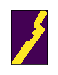

6090328993 centroid=(224015, 6831078)
	x_delta=272.0	y_delta=283.0
	area_cols=27	area_rows=28
	total_areas=756	valid_areas=300


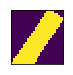

6090340818 centroid=(216232, 6828198)
	x_delta=423.0	y_delta=329.0
	area_cols=42	area_rows=33
	total_areas=1386	valid_areas=824


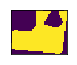

6090342838 centroid=(217616, 6829745)
	x_delta=501.0	y_delta=488.0
	area_cols=50	area_rows=49
	total_areas=2450	valid_areas=1306


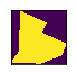

6090345161 centroid=(219408, 6832820)
	x_delta=423.0	y_delta=536.0
	area_cols=42	area_rows=54
	total_areas=2268	valid_areas=467


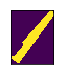

6090345969 centroid=(217630, 6830729)
	x_delta=411.0	y_delta=330.0
	area_cols=41	area_rows=33
	total_areas=1353	valid_areas=763


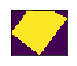

6090346171 centroid=(219473, 6832747)
	x_delta=410.0	y_delta=564.0
	area_cols=41	area_rows=56
	total_areas=2296	valid_areas=729


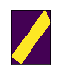

6090347888 centroid=(217386, 6828608)
	x_delta=363.0	y_delta=459.0
	area_cols=36	area_rows=46
	total_areas=1656	valid_areas=796


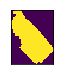

6090348292 centroid=(217845, 6829938)
	x_delta=402.0	y_delta=517.0
	area_cols=40	area_rows=52
	total_areas=2080	valid_areas=1090


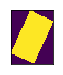

6090672133 centroid=(224590, 6830784)
	x_delta=551.0	y_delta=478.0
	area_cols=55	area_rows=48
	total_areas=2640	valid_areas=1527


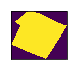

8860017483 centroid=(230872, 6827416)
	x_delta=355.0	y_delta=421.0
	area_cols=36	area_rows=42
	total_areas=1512	valid_areas=395


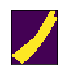

8860091851 centroid=(228871, 6827635)
	x_delta=308.0	y_delta=472.0
	area_cols=31	area_rows=47
	total_areas=1457	valid_areas=1044


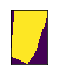

8860095891 centroid=(227890, 6826548)
	x_delta=269.0	y_delta=163.0
	area_cols=27	area_rows=16
	total_areas=432	valid_areas=249


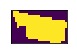

8860095992 centroid=(227438, 6826589)
	x_delta=725.0	y_delta=566.0
	area_cols=72	area_rows=57
	total_areas=4104	valid_areas=1888


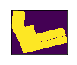

8860195925 centroid=(231084, 6827433)
	x_delta=357.0	y_delta=290.0
	area_cols=36	area_rows=29
	total_areas=1044	valid_areas=512


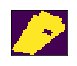

9880016034 centroid=(273380, 6808552)
	x_delta=366.0	y_delta=417.0
	area_cols=37	area_rows=42
	total_areas=1554	valid_areas=967


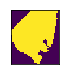

9880016135 centroid=(273894, 6808196)
	x_delta=543.0	y_delta=466.0
	area_cols=54	area_rows=47
	total_areas=2538	valid_areas=1304


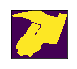

9880167291 centroid=(272602, 6810132)
	x_delta=209.0	y_delta=249.0
	area_cols=21	area_rows=25
	total_areas=525	valid_areas=275


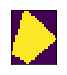

9880217714 centroid=(273030, 6810694)
	x_delta=283.0	y_delta=167.0
	area_cols=28	area_rows=17
	total_areas=476	valid_areas=272


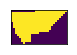

Total number of areas: 17779


In [4]:
builder.extract_area_grids()

### 2.3 Date wise dataset generation

The main part of this notebook is the creation of date wise training datasets from June 3rd 2017 to Sep 11th 2017. Because our dataset has a varying amount of NDVI, RGB and NSensor image data, we will build two datasets. The first dataset will contain only true datasets for each date, meaning no auxiliary measures are employed. The other then allows for handling the image data inputs as being valid for seven consecutive days. 

About the imagedate further, the core idea is to extract smaller areas corresponding to 10m x 10m blocks of field data. The satellite data has already the resolution of 1 px per 10 m, but the other image data sources have a resolution of 32 px per 10 m. These areas have to matched to ensure the time series is related to strictly a single area.

#### 2.3.1 Areas

In [5]:
builder.generate_areas()

6090006368
	Processed 119 Areas in 0 m 0.8 s
6090006469
	Processed 238 Areas in 0 m 1.7 s
6090161265
	Processed 717 Areas in 0 m 5.1 s
6090161366
	Processed 594 Areas in 0 m 4.3 s
6090205523
	Processed 377 Areas in 0 m 2.7 s
6090324751
	Processed 1026 Areas in 0 m 7.6 s
6090328993
	Processed 300 Areas in 0 m 2.2 s
6090340818
	Processed 824 Areas in 0 m 6.1 s
6090342838
	Processed 1306 Areas in 0 m 9.8 s
6090345161
	Processed 467 Areas in 0 m 3.5 s
6090345969
	Processed 763 Areas in 0 m 5.9 s
6090346171
	Processed 729 Areas in 0 m 5.5 s
6090347888
	Processed 796 Areas in 0 m 6.1 s
6090348292
	Processed 1090 Areas in 0 m 8.4 s
6090672133
	Processed 1527 Areas in 0 m 12.0 s
8860017483
	Processed 395 Areas in 0 m 3.1 s
8860091851
	Processed 1044 Areas in 0 m 8.4 s
8860095891
	Processed 249 Areas in 0 m 2.0 s
8860095992
	Processed 1888 Areas in 0 m 15.3 s
8860195925
	Processed 512 Areas in 0 m 4.2 s
9880016034
	Processed 967 Areas in 0 m 7.9 s
9880016135
	Processed 1304 Areas in 0 m 10.9 s


#### 2.3.2 DataPeriods

In [6]:
builder.generate_dataperiods()

6090006368
	Soil: True
	Processed 1904 DataPeriods in 0 m 39.3 s
6090006469
	Soil: True
	Processed 3808 DataPeriods in 1 m 22.1 s
6090161265
	Soil: False
	Processed 11472 DataPeriods in 4 m 2.4 s
6090161366
	Soil: True
	Processed 9504 DataPeriods in 5 m 14.9 s
6090205523
	Soil: True
	Processed 6032 DataPeriods in 4 m 27.4 s
6090324751
	Soil: False
	Processed 16416 DataPeriods in 33 m 24.6 s
6090328993
	Soil: True
	Processed 4800 DataPeriods in 3 m 28.8 s
6090340818
	Soil: False
	Processed 13184 DataPeriods in 4 m 55.8 s
6090342838
	Soil: True
	Processed 20896 DataPeriods in 9 m 52.2 s
6090345161
	Soil: True
	Processed 7472 DataPeriods in 5 m 58.7 s
6090345969
	Soil: False
	Processed 12208 DataPeriods in 11 m 36.3 s
6090346171
	Soil: True
	Processed 11664 DataPeriods in 11 m 7.7 s
6090347888
	Soil: True
	Processed 12736 DataPeriods in 15 m 34.9 s
6090348292
	Soil: True
	Processed 17440 DataPeriods in 9 m 28.5 s
6090672133
	Soil: True
	Processed 24432 DataPeriods in 38 m 15.6 s
886001748

The block's `6090347888` empty parts result from the RGB image missing a corner in the field.

#### 2.3.3 Targets

For some reason even if the Area's coordinates are correct, the exclusion of Area-corresponding projection from yield images results sometimes in an extra generated data row. Thus the code is implemented in a way to enforce brute force array resizing by excluding possible extra rows.

In [7]:
builder.generate_targets()

6090006368
	Processed 119 Targets in 0 m 1.6 s
6090006469
	Processed 238 Targets in 0 m 3.2 s
6090161265
	Processed 717 Targets in 0 m 9.8 s
6090161366
	Processed 594 Targets in 0 m 8.2 s
6090205523
	No yield data
6090324751
	Processed 1026 Targets in 0 m 14.5 s
6090328993
	Processed 300 Targets in 0 m 4.1 s
6090340818
	Processed 824 Targets in 0 m 11.4 s
6090342838
	Processed 1306 Targets in 0 m 18.2 s
6090345161
	Processed 467 Targets in 0 m 6.5 s
6090345969
	Processed 763 Targets in 0 m 10.6 s
6090346171
	Processed 729 Targets in 0 m 10.0 s
6090347888
	No yield data
6090348292
	Processed 1090 Targets in 0 m 15.1 s
6090672133
	Processed 1527 Targets in 0 m 21.4 s
8860017483
	No yield data
8860091851
	Processed 1044 Targets in 0 m 15.2 s
8860095891
	Processed 249 Targets in 0 m 3.6 s
8860095992
	Processed 1888 Targets in 0 m 26.5 s
8860195925
	No yield data
9880016034
	No yield data
9880016135
	No yield data
9880167291
	No yield data
9880217714
	No yield data
Processed 12881 Targets i

### 2.4 Projection window of 20m

Reading Soil data.. OK
Reading Weather data.. OK
Extracting Area grids..
6090006368 centroid=(224847, 6830937)
	x_delta=148.0	y_delta=122.0
	area_cols=14	area_rows=11
	total_areas=154	valid_areas=114


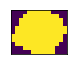

6090006469 centroid=(224658, 6831017)
	x_delta=291.0	y_delta=198.0
	area_cols=28	area_rows=19
	total_areas=532	valid_areas=241


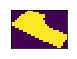

6090161265 centroid=(227622, 6827402)
	x_delta=289.0	y_delta=283.0
	area_cols=28	area_rows=27
	total_areas=756	valid_areas=704


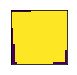

6090161366 centroid=(227632, 6827118)
	x_delta=243.0	y_delta=307.0
	area_cols=23	area_rows=30
	total_areas=690	valid_areas=594


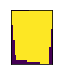

6090205523 centroid=(228685, 6831478)
	x_delta=324.0	y_delta=244.0
	area_cols=31	area_rows=23
	total_areas=713	valid_areas=377


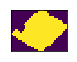

6090324751 centroid=(224262, 6831332)
	x_delta=535.0	y_delta=805.0
	area_cols=52	area_rows=80
	total_areas=4160	valid_areas=1026


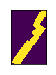

6090328993 centroid=(224015, 6831078)
	x_delta=272.0	y_delta=283.0
	area_cols=26	area_rows=27
	total_areas=702	valid_areas=290


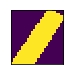

6090340818 centroid=(216232, 6828198)
	x_delta=423.0	y_delta=329.0
	area_cols=41	area_rows=32
	total_areas=1312	valid_areas=814


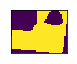

6090342838 centroid=(217616, 6829745)
	x_delta=501.0	y_delta=488.0
	area_cols=49	area_rows=48
	total_areas=2352	valid_areas=1304


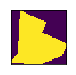

6090345161 centroid=(219408, 6832820)
	x_delta=423.0	y_delta=536.0
	area_cols=41	area_rows=53
	total_areas=2173	valid_areas=468


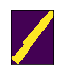

6090345969 centroid=(217630, 6830729)
	x_delta=411.0	y_delta=330.0
	area_cols=40	area_rows=32
	total_areas=1280	valid_areas=759


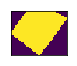

6090346171 centroid=(219473, 6832747)
	x_delta=410.0	y_delta=564.0
	area_cols=40	area_rows=55
	total_areas=2200	valid_areas=728


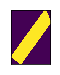

6090347888 centroid=(217386, 6828608)
	x_delta=363.0	y_delta=459.0
	area_cols=35	area_rows=45
	total_areas=1575	valid_areas=794


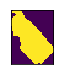

6090348292 centroid=(217845, 6829938)
	x_delta=402.0	y_delta=517.0
	area_cols=39	area_rows=51
	total_areas=1989	valid_areas=1088


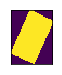

6090672133 centroid=(224590, 6830784)
	x_delta=551.0	y_delta=478.0
	area_cols=54	area_rows=47
	total_areas=2538	valid_areas=1526


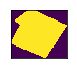

8860017483 centroid=(230872, 6827416)
	x_delta=355.0	y_delta=421.0
	area_cols=34	area_rows=41
	total_areas=1394	valid_areas=394


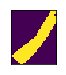

8860091851 centroid=(228871, 6827635)
	x_delta=308.0	y_delta=472.0
	area_cols=30	area_rows=46
	total_areas=1380	valid_areas=1034


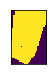

8860095891 centroid=(227890, 6826548)
	x_delta=269.0	y_delta=163.0
	area_cols=26	area_rows=15
	total_areas=390	valid_areas=251


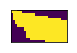

8860095992 centroid=(227438, 6826589)
	x_delta=725.0	y_delta=566.0
	area_cols=72	area_rows=56
	total_areas=4032	valid_areas=1885


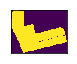

8860195925 centroid=(231084, 6827433)
	x_delta=357.0	y_delta=290.0
	area_cols=35	area_rows=28
	total_areas=980	valid_areas=513


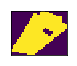

9880016034 centroid=(273380, 6808552)
	x_delta=366.0	y_delta=417.0
	area_cols=36	area_rows=41
	total_areas=1476	valid_areas=964


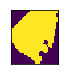

9880016135 centroid=(273894, 6808196)
	x_delta=543.0	y_delta=466.0
	area_cols=53	area_rows=46
	total_areas=2438	valid_areas=1306


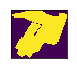

9880167291 centroid=(272602, 6810132)
	x_delta=209.0	y_delta=249.0
	area_cols=20	area_rows=24
	total_areas=480	valid_areas=275


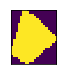

9880217714 centroid=(273030, 6810694)
	x_delta=283.0	y_delta=167.0
	area_cols=27	area_rows=16
	total_areas=432	valid_areas=271


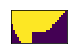

Total number of areas: 17720
6090006368
	Processed 114 Areas in 0 m 0.8 s
6090006469
	Processed 241 Areas in 0 m 1.5 s
6090161265
	Processed 704 Areas in 0 m 4.9 s
6090161366
	Processed 594 Areas in 0 m 4.1 s
6090205523
	Processed 377 Areas in 0 m 2.5 s
6090324751
	Processed 1026 Areas in 0 m 7.0 s
6090328993
	Processed 290 Areas in 0 m 2.0 s
6090340818
	Processed 814 Areas in 0 m 5.6 s
6090342838
	Processed 1304 Areas in 0 m 8.9 s
6090345161
	Processed 468 Areas in 0 m 3.3 s
6090345969
	Processed 759 Areas in 0 m 5.3 s
6090346171
	Processed 728 Areas in 0 m 5.2 s
6090347888
	Processed 794 Areas in 0 m 5.6 s
6090348292
	Processed 1088 Areas in 0 m 8.3 s
6090672133
	Processed 1526 Areas in 0 m 11.3 s
8860017483
	Processed 394 Areas in 0 m 2.9 s
8860091851
	Processed 1034 Areas in 0 m 8.0 s
8860095891
	Processed 251 Areas in 0 m 1.9 s
8860095992
	Processed 1885 Areas in 0 m 14.3 s
8860195925
	Processed 513 Areas in 0 m 3.9 s
9880016034
	Processed 964 Areas in 0 m 7.6 s
9880016135
	Proces

In [1]:
from field_analysis.db.dataset import DatasetBuilder
builder = DatasetBuilder(initialize=True, area_size_meters=20, area_size_px=64)
builder.build_dataset()

In [2]:
from field_analysis.db.models import Area, DataPeriod, Target
print("Number of Areas:",Area.select().count())
print("Number of DataPeriods:",DataPeriod.select().count())
print("Number of Targets:",Target.select().count())

Number of Areas: 17720
Number of DataPeriods: 283520
Number of Targets: 12826


### 2.5 Projection window of 40m

Reading Soil data.. OK
Reading Weather data.. OK
Extracting Area grids..
6090006368 centroid=(224847, 6830937)
	x_delta=148.0	y_delta=122.0
	area_cols=12	area_rows=9
	total_areas=108	valid_areas=98


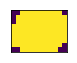

6090006469 centroid=(224658, 6831017)
	x_delta=291.0	y_delta=198.0
	area_cols=26	area_rows=17
	total_areas=442	valid_areas=231


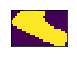

6090161265 centroid=(227622, 6827402)
	x_delta=289.0	y_delta=283.0
	area_cols=26	area_rows=25
	total_areas=650	valid_areas=641


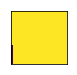

6090161366 centroid=(227632, 6827118)
	x_delta=243.0	y_delta=307.0
	area_cols=21	area_rows=28
	total_areas=588	valid_areas=558


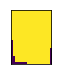

6090205523 centroid=(228685, 6831478)
	x_delta=324.0	y_delta=244.0
	area_cols=29	area_rows=21
	total_areas=609	valid_areas=368


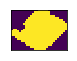

6090324751 centroid=(224262, 6831332)
	x_delta=535.0	y_delta=805.0
	area_cols=50	area_rows=78
	total_areas=3900	valid_areas=1011


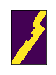

6090328993 centroid=(224015, 6831078)
	x_delta=272.0	y_delta=283.0
	area_cols=24	area_rows=25
	total_areas=600	valid_areas=273


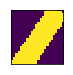

6090340818 centroid=(216232, 6828198)
	x_delta=423.0	y_delta=329.0
	area_cols=39	area_rows=30
	total_areas=1170	valid_areas=772


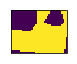

6090342838 centroid=(217616, 6829745)
	x_delta=501.0	y_delta=488.0
	area_cols=47	area_rows=46
	total_areas=2162	valid_areas=1280


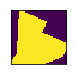

6090345161 centroid=(219408, 6832820)
	x_delta=423.0	y_delta=536.0
	area_cols=39	area_rows=51
	total_areas=1989	valid_areas=459


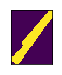

6090345969 centroid=(217630, 6830729)
	x_delta=411.0	y_delta=330.0
	area_cols=38	area_rows=30
	total_areas=1140	valid_areas=739


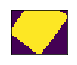

6090346171 centroid=(219473, 6832747)
	x_delta=410.0	y_delta=564.0
	area_cols=38	area_rows=53
	total_areas=2014	valid_areas=718


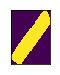

6090347888 centroid=(217386, 6828608)
	x_delta=363.0	y_delta=459.0
	area_cols=33	area_rows=43
	total_areas=1419	valid_areas=778


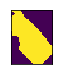

6090348292 centroid=(217845, 6829938)
	x_delta=402.0	y_delta=517.0
	area_cols=37	area_rows=49
	total_areas=1813	valid_areas=1079


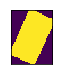

6090672133 centroid=(224590, 6830784)
	x_delta=551.0	y_delta=478.0
	area_cols=52	area_rows=45
	total_areas=2340	valid_areas=1514


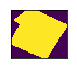

8860017483 centroid=(230872, 6827416)
	x_delta=355.0	y_delta=421.0
	area_cols=32	area_rows=39
	total_areas=1248	valid_areas=381


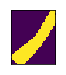

8860091851 centroid=(228871, 6827635)
	x_delta=308.0	y_delta=472.0
	area_cols=28	area_rows=44
	total_areas=1232	valid_areas=990


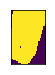

8860095891 centroid=(227890, 6826548)
	x_delta=269.0	y_delta=163.0
	area_cols=24	area_rows=13
	total_areas=312	valid_areas=228


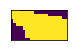

8860095992 centroid=(227438, 6826589)
	x_delta=725.0	y_delta=566.0
	area_cols=70	area_rows=54
	total_areas=3780	valid_areas=1864


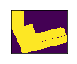

8860195925 centroid=(231084, 6827433)
	x_delta=357.0	y_delta=290.0
	area_cols=33	area_rows=26
	total_areas=858	valid_areas=501


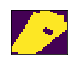

9880016034 centroid=(273380, 6808552)
	x_delta=366.0	y_delta=417.0
	area_cols=34	area_rows=39
	total_areas=1326	valid_areas=932


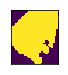

9880016135 centroid=(273894, 6808196)
	x_delta=543.0	y_delta=466.0
	area_cols=51	area_rows=44
	total_areas=2244	valid_areas=1294


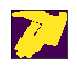

9880167291 centroid=(272602, 6810132)
	x_delta=209.0	y_delta=249.0
	area_cols=18	area_rows=22
	total_areas=396	valid_areas=265


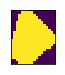

9880217714 centroid=(273030, 6810694)
	x_delta=283.0	y_delta=167.0
	area_cols=25	area_rows=14
	total_areas=350	valid_areas=233


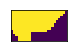

Total number of areas: 17207
6090006368
	Processed 98 Areas in 0 m 0.7 s
6090006469
	Processed 231 Areas in 0 m 1.7 s
6090161265
	Processed 641 Areas in 0 m 4.6 s
6090161366
	Processed 558 Areas in 0 m 3.9 s
6090205523
	Processed 368 Areas in 0 m 2.6 s
6090324751
	Processed 1011 Areas in 0 m 7.0 s
6090328993
	Processed 273 Areas in 0 m 2.0 s
6090340818
	Processed 772 Areas in 0 m 5.4 s
6090342838
	Processed 1280 Areas in 0 m 9.0 s
6090345161
	Processed 459 Areas in 0 m 3.3 s
6090345969
	Processed 739 Areas in 0 m 5.4 s
6090346171
	Processed 718 Areas in 0 m 5.2 s
6090347888
	Processed 778 Areas in 0 m 5.7 s
6090348292
	Processed 1079 Areas in 0 m 8.0 s
6090672133
	Processed 1514 Areas in 0 m 11.9 s
8860017483
	Processed 381 Areas in 0 m 3.0 s
8860091851
	Processed 990 Areas in 0 m 7.9 s
8860095891
	Processed 228 Areas in 0 m 1.8 s
8860095992
	Processed 1864 Areas in 0 m 14.8 s
8860195925
	Processed 501 Areas in 0 m 4.0 s
9880016034
	Processed 932 Areas in 0 m 7.5 s
9880016135
	Processe

In [1]:
from field_analysis.db.dataset import DatasetBuilder
builder = DatasetBuilder(initialize=True, area_size_meters=40, area_size_px=128)
builder.build_dataset()

In [2]:
from field_analysis.db.models import Area, DataPeriod, Target
print("Number of Areas:",Area.select().count())
print("Number of DataPeriods:",DataPeriod.select().count())
print("Number of Targets:",Target.select().count())

Number of Areas: 17207
Number of DataPeriods: 275312
Number of Targets: 12455


## 3. Selecting Test samples

Due to the developmental nature of the process, a demand to explicitly select a random subset of samples as test samples emerged. This will be thus done by first adding a corresponding field to the ``DataPeriod``-table. After that we will select randomly 15% of our datasets. Due to the nature of our implementation, we will need a field for each ``DataPeriodDataset`` instance so that we don't accidentally reserve more samples for testing purposes than intended.

### 3.1 Creating the fields

First we create the necessary boolean fields, which are

- ``test_ndvi_earlier``
- ``test_ndvi_later``
- ``test_rgb_earlier``
- ``test_rgb_later``

In [1]:
import os
import datetime
import numpy as np
import peewee as pw
from field_analysis.db.models import DataPeriod, Area, Target, initialize_db, db
import field_analysis.settings.model as model_settings

db_32 = 'field_analysis_10m_32px.db'
db_64 = 'field_analysis_20m_64px.db'
db_128 = 'field_analysis_40m_128px.db'
dbs = [db_32, db_64, db_128]

In [2]:
for db_name in dbs:
    print(db_name)
    initialize_db(os.path.join(model_settings.DATABASES_DIR,db_name))
    for column in ["test_ndvi_earlier","test_ndvi_later","test_rgb_earlier","test_rgb_later"]:
        try:
            db.execute_sql(sql=f"ALTER TABLE dataperiod ADD COLUMN {column} INTEGER DEFAULT 0;")
        except pw.OperationalError as ex:
            print(f"  OperationalError: {ex}")
    print("  Last four columns of the table:")
    [print(f"    {table_column.name} {table_column.data_type}") for table_column in db.get_columns(table='dataperiod')[-4:]]
    print()

field_analysis_10m_32px.db
  Last four columns of the table:
    test_ndvi_earlier INTEGER
    test_ndvi_later INTEGER
    test_rgb_earlier INTEGER
    test_rgb_later INTEGER

field_analysis_20m_64px.db
  Last four columns of the table:
    test_ndvi_earlier INTEGER
    test_ndvi_later INTEGER
    test_rgb_earlier INTEGER
    test_rgb_later INTEGER

field_analysis_40m_128px.db
  Last four columns of the table:
    test_ndvi_earlier INTEGER
    test_ndvi_later INTEGER
    test_rgb_earlier INTEGER
    test_rgb_later INTEGER



### 3.2 Labeling the samples

Then we collect 15% of every dataset and label the collected samples as test samples. We will collect data separately for the following settings:

 - NDVI earlier
 - NDVI later
 - RGB earlier
 - RGB later
 
The point of determination date-wise is 1st of July of the data collection year.

In [3]:
DATE_DIVIDER = datetime.date(2017, 7, 1)
for db_name in dbs:
    print(db_name)
    initialize_db(os.path.join(model_settings.DATABASES_DIR,db_name))
    
    print(f"  NDVI Early")
    ndvi_early = (DataPeriod
        .select(DataPeriod.date,
                DataPeriod.area_drone_ndvi,
                DataPeriod.test_ndvi_earlier,
                Area.id,
                Target.area_yield)
        .join(Area)
        .join(Target)
        .where(
            (DataPeriod.area_drone_ndvi.is_null(False)) &
            (DataPeriod.date < DATE_DIVIDER) &
            (Target.area_yield.is_null(False))))
    sample_count = ndvi_early.count()
    test_sample_count = round(sample_count*.15)
    test_sample_ids = np.random.randint(low=0,high=sample_count,size=test_sample_count)
    print(f"    {sample_count} total samples")
    print(f"    {test_sample_count} test samples")
    hit_count = 0
    for i in test_sample_ids:
        sample = ndvi_early[i]
        sample.test_ndvi_earlier = 1
        hit_count += sample.save()
    print(f"    Modified {hit_count} rows.")

    print(f"  NDVI Later")
    ndvi_later = (DataPeriod
        .select(DataPeriod.date,
                DataPeriod.area_drone_ndvi,
                DataPeriod.test_ndvi_later,
                Area.id,
                Target.area_yield)
        .join(Area)
        .join(Target)
        .where(
            (DataPeriod.area_drone_ndvi.is_null(False)) &
            (DataPeriod.date >= DATE_DIVIDER) &
            (Target.area_yield.is_null(False))))
    sample_count = ndvi_later.count()
    test_sample_count = round(sample_count*.15)
    test_sample_ids = np.random.randint(low=0,high=sample_count,size=test_sample_count)
    print(f"    {sample_count} total samples")
    print(f"    {test_sample_count} test samples")
    hit_count = 0
    for i in test_sample_ids:
        sample = ndvi_later[i]
        sample.test_ndvi_later = 1
        hit_count += sample.save()
    print(f"    Modified {hit_count} rows.")

    print(f"  RGB Earlier")
    rgb_earlier = (DataPeriod
        .select(DataPeriod.date,
                DataPeriod.area_drone_rgb,
                DataPeriod.test_rgb_earlier,
                Area.id,
                Target.area_yield)
        .join(Area)
        .join(Target)
        .where(
            (DataPeriod.area_drone_rgb.is_null(False)) &
            (DataPeriod.date < DATE_DIVIDER) &
            (Target.area_yield.is_null(False))))
    sample_count = rgb_earlier.count()
    test_sample_count = round(sample_count*.15)
    test_sample_ids = np.random.randint(low=0,high=sample_count,size=test_sample_count)
    print(f"    {sample_count} total samples")
    print(f"    {test_sample_count} test samples")
    hit_count = 0
    for i in test_sample_ids:
        sample = rgb_earlier[i]
        sample.test_rgb_earlier = 1
        hit_count += sample.save()
    print(f"    Modified {hit_count} rows.")

    print(f"  RGB Later")
    rgb_later = (DataPeriod
        .select(DataPeriod.date,
                DataPeriod.area_drone_rgb,
                DataPeriod.test_rgb_earlier,
                Area.id,
                Target.area_yield)
        .join(Area)
        .join(Target)
        .where(
            (DataPeriod.area_drone_rgb.is_null(False)) &
            (DataPeriod.date >= DATE_DIVIDER) &
            (Target.area_yield.is_null(False))))
    sample_count = rgb_later.count()
    test_sample_count = round(sample_count*.15)
    test_sample_ids = np.random.randint(low=0,high=sample_count,size=test_sample_count)
    print(f"    {sample_count} total samples")
    print(f"    {test_sample_count} test samples")
    hit_count = 0
    for i in test_sample_ids:
        sample = rgb_later[i]
        sample.test_rgb_later = 1
        hit_count += sample.save()
    print(f"    Modified {hit_count} rows.")

field_analysis_10m_32px.db
  NDVI Early
    5286 total samples
    793 test samples
    Modified 793 rows.
  NDVI Later
    5197 total samples
    780 test samples
    Modified 780 rows.
  RGB Earlier
    5241 total samples
    786 test samples
    Modified 786 rows.
  RGB Later
    4647 total samples
    697 test samples
    Modified 697 rows.
field_analysis_20m_64px.db
  NDVI Early
    5301 total samples
    795 test samples
    Modified 795 rows.
  NDVI Later
    5194 total samples
    779 test samples
    Modified 779 rows.
  RGB Earlier
    5262 total samples
    789 test samples
    Modified 789 rows.
  RGB Later
    4647 total samples
    697 test samples
    Modified 697 rows.
field_analysis_40m_128px.db
  NDVI Early
    5273 total samples
    791 test samples
    Modified 791 rows.
  NDVI Later
    5103 total samples
    765 test samples
    Modified 765 rows.
  RGB Earlier
    5248 total samples
    787 test samples
    Modified 787 rows.
  RGB Later
    4569 total samples
  

## 4. Generated dataset content overview

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from IPython.display import display

from field_analysis.db.models import Area, DataPeriod, Target, initialize_db
import field_analysis.settings.model as settings

db_32 = 'field_analysis_10m_32px.db'
initialize_db(os.path.join(settings.DATABASES_DIR,db_32))

### 4.1 DB entries' overview

Before proceeding, it is firmly in place to validate the generated contents. We will here make sure that the number of areas is correct, the number of date and area wise rows matches etc. As our date range is from 3.6.2017 to 11.9.2017, we should have as many dataperiods per area as there are days on the range.

In [2]:
print("Areas count:",Area.select().count())
print("DataPeriod count:",DataPeriod.select().count())
print("DataPeriods per Area:",DataPeriod.select().count()/Area.select().count())
print("Target count:",Target.select().count())
print("Targets per Area:",Target.select().count()/Area.select().count())

Areas count: 16767
DataPeriod count: 275324
DataPeriods per Area: 16.420588059879524
Target count: 11869
Targets per Area: 0.7078785710025646


### 4.2 Sample Area examination

Next we examine a single Area record. We also list the Block image datasets accompanied with it.

In [3]:
area = Area.get()
display(area.__data__)

{'id': 1,
 'block_id': 6090006368,
 'top_left_x': 224813.0,
 'top_left_y': 6830998.0,
 'bot_right_x': 224823.0,
 'bot_right_y': 6830988.0}

The possible auxiliary xml-files which are a by-product of examining the images with QGIS are disregarded during processing, thus we omit them here as well. This means that the Area should have a maximum of 7 Sentinel NDVI datasets in its DataPeriods with no Drone datasets at all. 

### 4.3 Sample Area's DataPeriods

Lets examine them, the DataPeriods, next. We'll fetch Area-wise DataPeriods and examine the first.

In [4]:
dps = DataPeriod.select().where(DataPeriod.area == area.id)
print("Fetched",dps.count(),"DataPeriods for Area with id",area.id)

for dp in list(dps):
    print("Single DataPeriod:")
    display(dp.__data__)
    break    

Fetched 16 DataPeriods for Area with id 1
Single DataPeriod:


{'id': 1,
 'area': 1,
 'date': datetime.datetime(2017, 6, 1, 0, 0),
 'test_ndvi_earlier': False,
 'test_ndvi_later': False,
 'test_rgb_earlier': False,
 'test_rgb_later': False,
 'area_sentinel': None,
 'area_drone_ndvi': None,
 'area_drone_rgb': None,
 'block_sentinel_mean': 0.21163975447416306,
 'block_sentinel_median': 0.1562574803829193,
 'block_drone_ndvi_mean': None,
 'block_drone_ndvi_median': None,
 'block_drone_rgb_mean': None,
 'block_drone_rgb_median': None,
 'soil_type_cat': 'KHt',
 'soil_earthiness_cat': 'm',
 'soil_conductivity': 0.9,
 'soil_acidity': 6.8,
 'soil_calcium': 1300.0,
 'soil_phosphorus': 21.0,
 'soil_potassium': 110.0,
 'soil_magnesium': 130.0,
 'soil_sulphur': 7.8,
 'soil_copper': 4.0,
 'soil_manganese': 17.0,
 'soil_zinc': 1.7,
 'soil_cec': 9.0,
 'soil_cec_ca': 74.0,
 'soil_cec_k': 3.0,
 'soil_cec_mg': 13.0,
 'soil_cec_na': 3.0,
 'weather_air_temperature_mean': 10.955312810327724,
 'weather_cloud_amount_mean': 2.750744786494538,
 'weather_dewpoint_temperatu

What is striking is that there should be an accompanied Sentinel dataset. As there exists a mean and a median value, it is a signal that one indeed exists. As the Area in question is the first, it is also in the top left corner of the associated Block's raster. The code has been implemented in such a way that if all the distinct DataPeriod's image's pixel values are `nan`, we simply just mark the dataset as `None`. So far so good.

### 4.4 Sample Area's Target

Then we'll move on to Target values. We'll use the already retrieved Area to fetch it's related Target.

mean=6499, median=6652


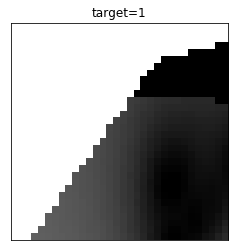

In [7]:
target = Target.select().where(Target.area == area)[0]
print("mean={:.0f}, median={:.0f}".format(target.block_yield_mean,target.block_yield_median))
arr = pickle.loads(target.area_yield)

plt.imshow(arr,cmap='gray',vmin=1500,vmax=15000)
plt.title("target={}".format(target.id))
plt.xticks([])
plt.yticks([])
plt.show()

The area seems to be properly equipped with a target! Great.

### 4.6 Multiple targets

Let's visualize more targets. While it would be nice to have the field represented in fully, only Areas within the Block's boundaries have been persisted. This means that the overall boundary is not rectangular, but a polygon. Thus it the visualization of the Block as it really is isn't feasible without larger missing Area imputations etc.

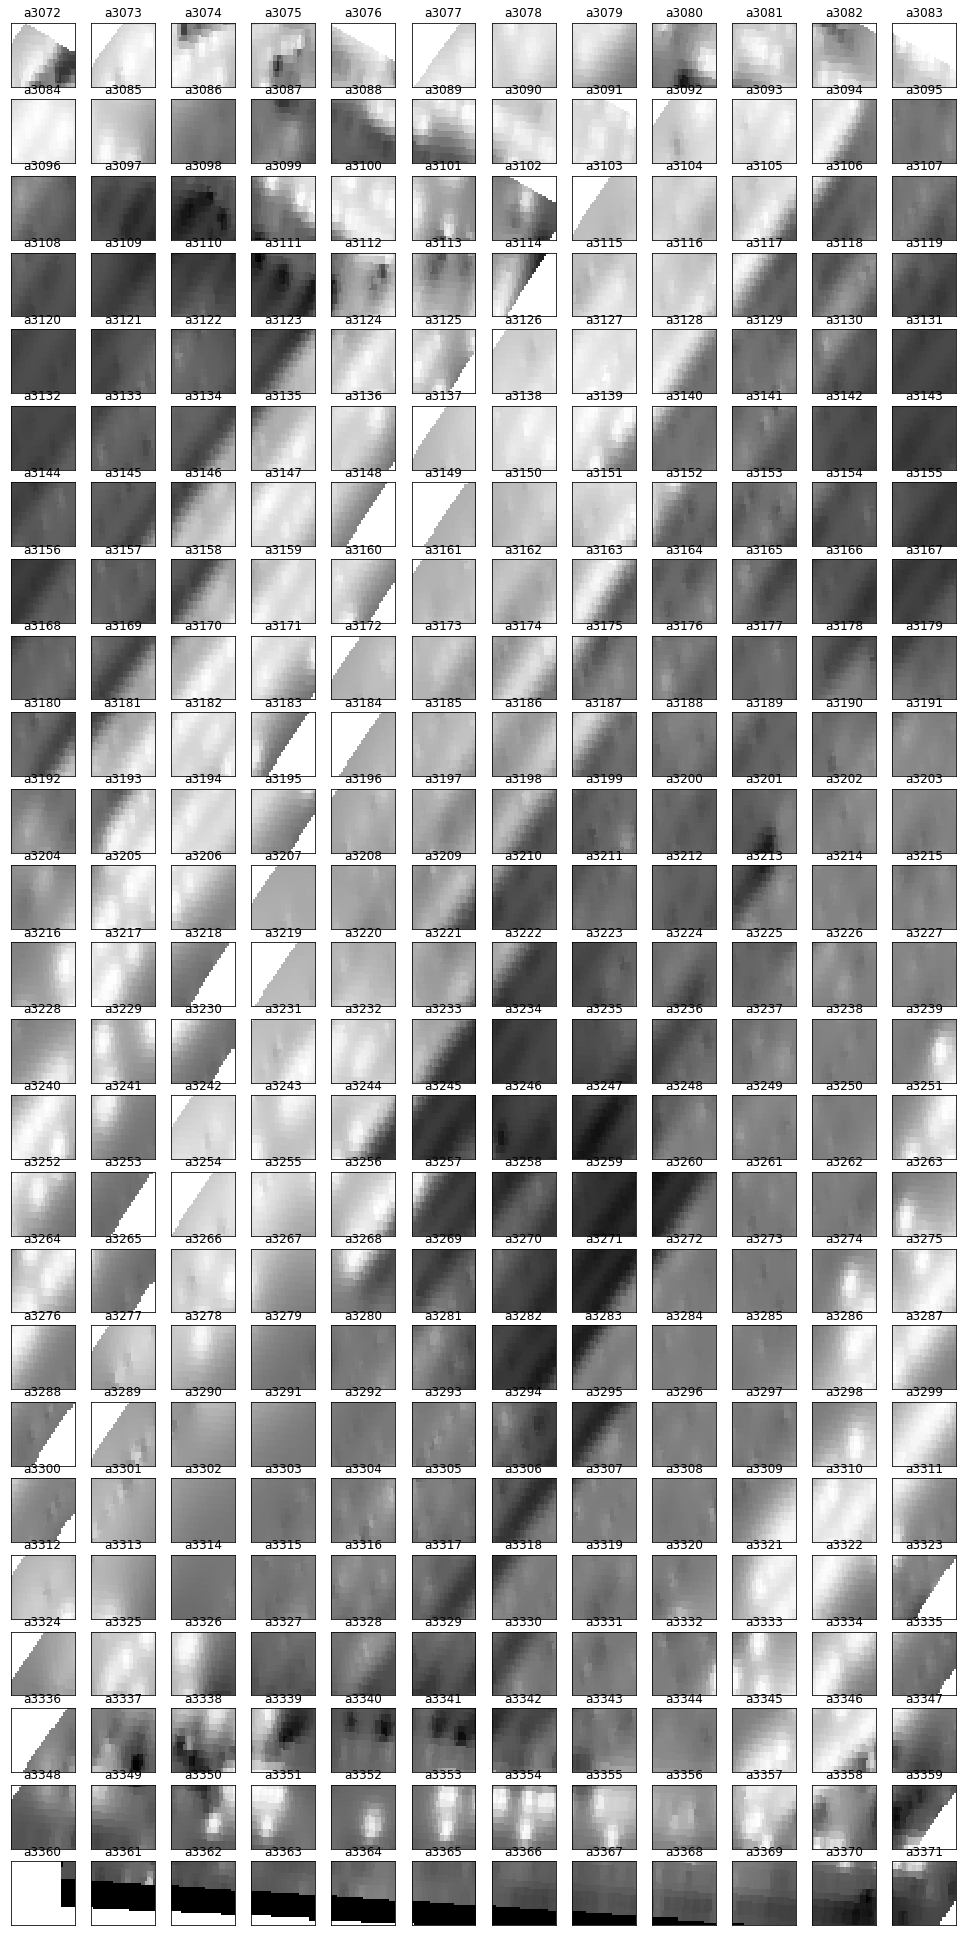

In [8]:
targets = Target.select().join(Area).where(Area.block_id == drone_block)

plt.rcParams['figure.figsize'] = 17,35
for i, target in enumerate(targets):
    
    arr = pickle.loads(target.area_yield)
    
    plt.subplot(25,12,i+1)
    plt.imshow(arr,cmap='gray',vmin=1500,vmax=15000)
    plt.title("a{}".format(target.area_id))
    plt.xticks([])
    plt.yticks([])

plt.show()

There exists a nice variation between across the Area-wise yield Targets.

### 4.7 RGB-NDVI pairs

Then we'll visualize pairs of Drone images. We compare the images Area-wise for each distinct date there exists both an RGB and an NDVI dataset. The aim of the comparison is to make sure that the images are aligned, meaning the images for an Area speak of the same part of the actual field. We will sample a random batch of DataPeriods for visualization.

In [6]:
dataperiods = (DataPeriod
               .select(DataPeriod.id, DataPeriod.area, DataPeriod.area_drone_ndvi, DataPeriod.area_drone_rgb)
               .where((DataPeriod.area_drone_ndvi.is_null(False)) & DataPeriod.area_drone_rgb.is_null(False)))
print("Retrieved {} DataPeriods".format(dataperiods.count()))

Retrieved 12449 DataPeriods


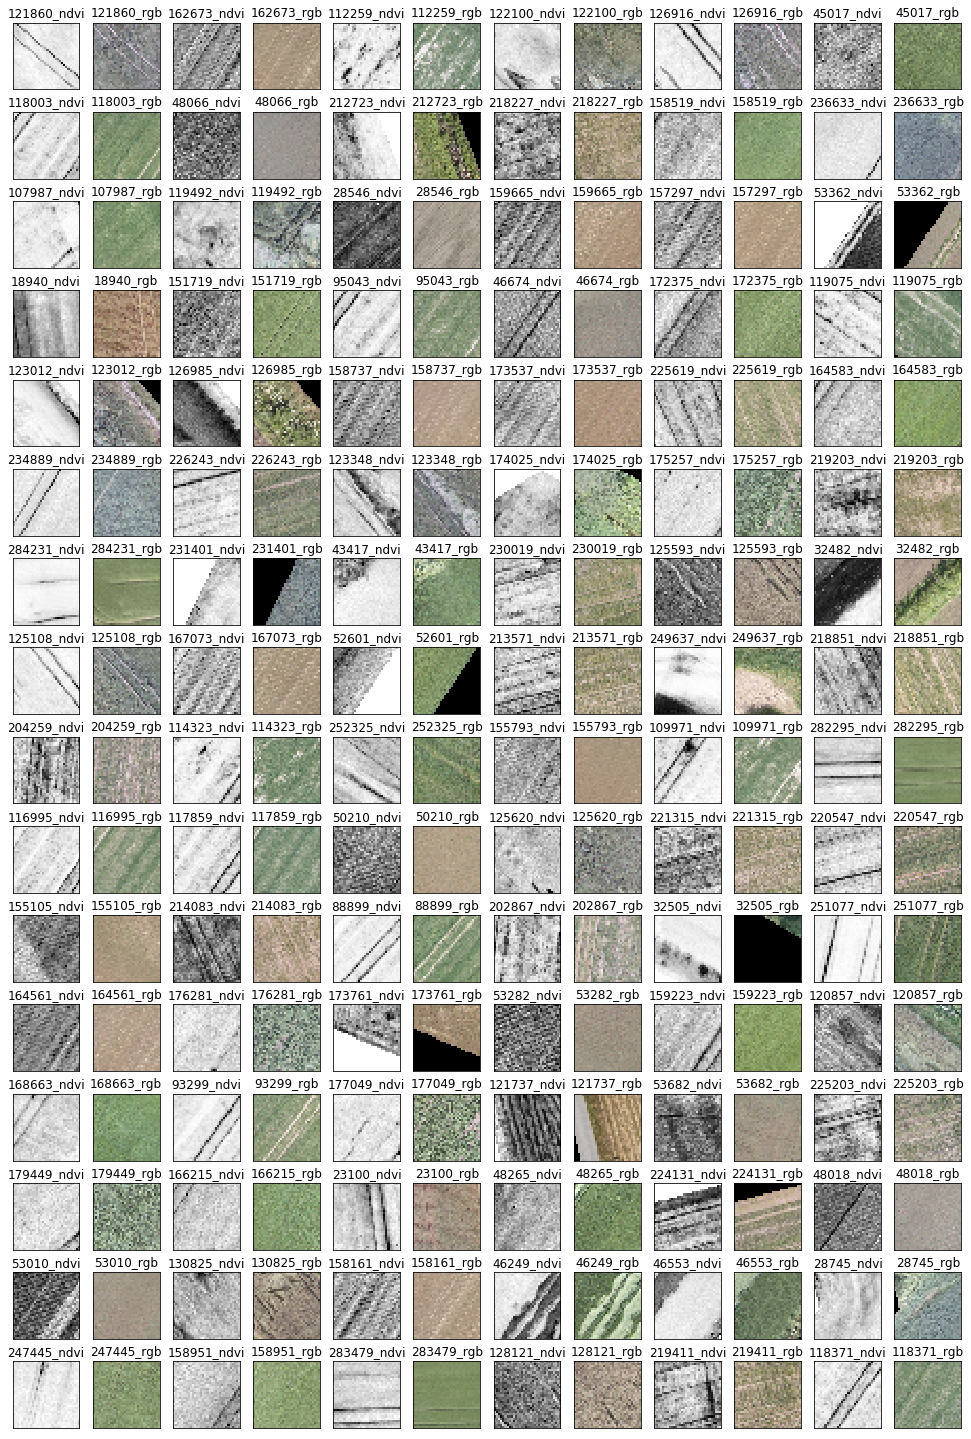

In [7]:
plt.rcParams['figure.figsize'] = 17,26

rows, cols = 16, 12
sample_is = np.round(np.random.rand(int(rows*cols/2))*dataperiods.count()).astype(int).tolist()

i = 1
for sample_i in sample_is:
    
    dataperiod = dataperiods[sample_i]
        
    plt.subplot(rows,cols,i)
    plt.imshow(pickle.loads(dataperiod.area_drone_ndvi), cmap='gray')
    plt.title('{}_ndvi'.format(dataperiod.id))
    plt.xticks([])
    plt.yticks([])

    i += 1

    plt.subplot(rows,cols,i)
    plt.imshow(pickle.loads(dataperiod.area_drone_rgb))
    plt.title('{}_rgb'.format(dataperiod.id))
    plt.xticks([])
    plt.yticks([])

    i += 1

plt.show()

### 4.8 Target value distributions

We are also interested in how the yields are distributed across the dataset. Let's pull up the yield means and do some analysis.

/home/nevavuor/.conda/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: Mean of empty slice.
/home/nevavuor/.conda/envs/pytorch/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


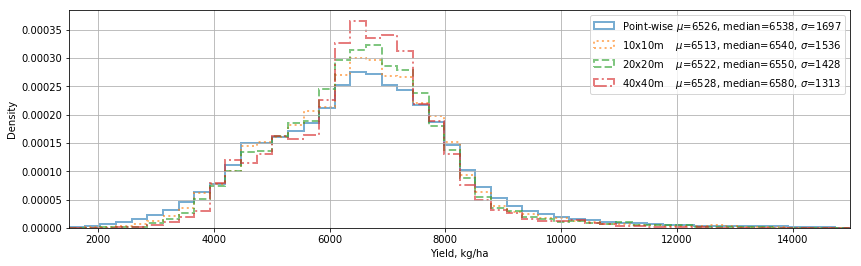

In [9]:
plt.rcParams['figure.figsize'] = 14, 4
linestyles = [':', '--', '-.']

rows = Target.select().where(Target.area_yield != None)
yields = []
for row in rows:
    area_yield = pickle.loads(row.area_yield)
    yields.append(area_yield)
yields = np.nan_to_num(np.array(yields).flat)
yields = yields[yields > 0]

label_window = "Point-wise "
label_content = "$\mu$={:.0f}, median={:.0f}, $\sigma$={:.0f}".format(
    yields.mean(), np.median(yields), yields.std())
plt.hist(yields, bins=50, range=(1500, 15000), alpha=0.6, histtype='step', lw=2,
         density=True, label=label_window+label_content)

db_32 = 'field_analysis_10m_32px.db'
db_64 = 'field_analysis_20m_64px.db'
db_128 = 'field_analysis_40m_128px.db'
dbs = [db_32, db_64, db_128]

for i in range(3):

    initialize_db(os.path.join(settings.DATABASES_DIR,dbs[i]))
    rows = Target.select().where(Target.area_yield != None)
    yields = []
    for row in rows:
        area_yield = pickle.loads(row.area_yield)
        area_yield = np.nan_to_num(area_yield).flat
        area_yield = area_yield[area_yield > 0]
        yields.append(area_yield.mean())
    yields = np.nan_to_num(np.array(yields))

    label_window = "{}x{}m{}".format(10*2**i, 10*2**i, " "*4)
    label_content = "$\mu$={:.0f}, median={:.0f}, $\sigma$={:.0f}".format(
        yields.mean(), np.median(yields), yields.std())
    plt.hist(yields, bins=50, range=(1500, 15000), alpha=0.6, histtype='step', lw=2,
             linestyle=linestyles[i], density=True, label=label_window+label_content)

plt.xlabel('Yield, kg/ha')
plt.ylabel('Density')
plt.xlim(1500, 15000)
plt.legend()
plt.grid()
plt.savefig(os.path.join(os.getcwd(), 'results', 'yield-densities.png'),
            dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

### 4.9 Input-target pairs

As visualizations are usually better than verbose descriptions, we'll visualize some input-target pairs.

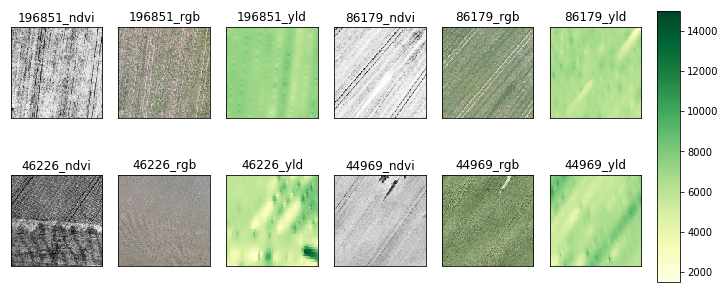

In [6]:
import matplotlib
from matplotlib.gridspec import GridSpec

dataperiods = (DataPeriod
               .select(DataPeriod.id,
                       DataPeriod.area,
                       DataPeriod.date,
                       DataPeriod.area_drone_ndvi,
                       DataPeriod.area_drone_rgb,
                       Target.area_yield)
               .where((DataPeriod.area_drone_ndvi.is_null(False)) &
                      DataPeriod.area_drone_rgb.is_null(False))
               .join(Target, on=(Target.area == DataPeriod.area))
               .where(Target.area_yield.is_null(False)))

rows, cols = 2, 6

plt.rcParams['figure.figsize'] = 12, 5
gs = GridSpec(nrows=rows, ncols=cols+1, width_ratios=[4]*cols+[1])

sample_is = np.random.randint(0, dataperiods.count(), size=int(rows*cols/3))

row = -1

for i,sample_i in enumerate(sample_is):
    
    if i%2 == 0:
        
        col = 0
        row += 1
    
    dataperiod = dataperiods[sample_i]

    plt.subplot(gs[row, col])
    plt.imshow(pickle.loads(dataperiod.area_drone_ndvi), cmap='gray')
    plt.title('{}_ndvi'.format(dataperiod.id))
    plt.xticks([])
    plt.yticks([])

    col += 1

    plt.subplot(gs[row, col])
    plt.imshow(pickle.loads(dataperiod.area_drone_rgb))
    plt.title('{}_rgb'.format(dataperiod.id))
    plt.xticks([])
    plt.yticks([])

    col += 1

    plt.subplot(gs[row, col])
    plt.imshow(pickle.loads(dataperiod.target.area_yield),
               cmap='YlGn', vmin=1500, vmax=15000)
    plt.title('{}_yld'.format(dataperiod.id))
    plt.xticks([])
    plt.yticks([])

    col += 1
    

axes = plt.subplot(gs[0:rows,cols])
plt.colorbar(cax=axes, cmap='YlGn')
plt.savefig(os.path.join(os.getcwd(),'results','input-target-comparison.png'),
            dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

### 4.10 Field-wise and date-wise statistics

Let's also print out information about the fields containing proper input-target pairs.

In [11]:
import datetime
import os
import pickle
import pandas as pd
import numpy as np

from field_analysis.db.models import Area, DataPeriod, Target, initialize_db
import field_analysis.settings.model as model_settings

db_32 = 'field_analysis_10m_32px.db'
initialize_db(os.path.join(model_settings.DATABASES_DIR,db_32))
areas = (Area.select(Area.block_id,
                     Target.area_yield,
                     Target.id,
                     DataPeriod.area_drone_ndvi,
                     DataPeriod.area_drone_rgb)
         .join(Target)
         .where(Target.area_yield != None)
         .join(DataPeriod, on=(DataPeriod.area == Target.area))
         .where(DataPeriod.area_drone_ndvi.is_null(False) |
                DataPeriod.area_drone_rgb.is_null(False)))

block_ids = [area.block_id for area in areas]
indices = pd.MultiIndex(levels=[[], []], labels=[
                        [], []], names=['block_id', 'date'])
blocks = pd.DataFrame(index=indices, columns=['mean_yield'])

for block_id in np.unique(block_ids):
    block_areas = areas.where(Area.block_id == block_id)
    block_yields = block_areas.select(
        Target.id, Target.area_yield).distinct()
    yields = []
    for block_yield in block_yields:
        yield_arr = np.nan_to_num(
            pickle.loads(block_yield.target.area_yield))
        yields.append(yield_arr)
    yields = np.nan_to_num(np.array(yields).flat)
    yields = yields[yields > 0]
    mean_yield = np.mean(yields)
    block_dates = block_areas.select(DataPeriod.date).distinct()
    for block_date in block_dates:
        date = block_date.target.dataperiod.date

        date_str = "{}.{}.".format(date.day, date.month)
        blocks.loc[(block_id, date_str),
                   ('mean_yield')] = mean_yield

blocks_backup = blocks

In [12]:
blocks

mean_yield
block_id   date            
6090161366 17.8.    5097.68
6090324751 8.6.     6054.21
           27.7.    6054.21
6090328993 8.6.     8971.21
           27.7.    8971.21
6090342838 6.7.     4673.14
6090345161 15.6.    6481.82
6090346171 15.6.    6883.57
6090348292 6.7.     7567.59
6090672133 13.7.    7584.97
           1.6.     7584.97
8860095992 15.6.    6990.67
           6.7.     6990.67

## 5. Troubleshooting

Last phase is to troubleshoot the specific anomalies.

In [18]:
import os
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pickle

from osgeo import gdal

from field_analysis.db.models import Area, DataPeriod, Target
from field_analysis import settings

### 5.1 Black RGB images - Resolved

> Problem was resolved by checking for None-only images only after hard-limiting the image shape.

Especially interesting are the black RGB images. Let's inspect a single DataPeriod with a black RGB image.

Block 6090672133 , Date 2017-06-01


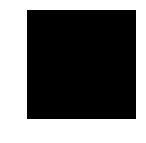

Data min/max=[nan, nan]
Block-wise RGB mean=0.6024262665183996


In [30]:
plt.rcParams['figure.figsize'] = 3,2

test_dp = DataPeriod.get(DataPeriod.id == 154849)
print("Block",test_dp.area.block_id,", Date",str(test_dp.date.date()))

arr = pickle.loads(test_dp.area_drone_rgb)
plt.imshow(arr)
plt.axis('off')
plt.show()

print("Data min/max=[{}, {}]".format(arr.min(),arr.max()))
print("Block-wise RGB mean={}".format(test_dp.block_drone_rgb_mean))

Let's further examine all the RGB images for that single Block and date.

In [34]:
block_id = test_dp.area.block_id
date = test_dp.date

dps = (DataPeriod
       .select()
       .where(DataPeriod.date == date)
       .join(Area)
       .where(Area.block_id == block_id))
print("Retrieved {} DataPeriods for Block {}".format(dps.count(),block_id), end=", ")

dps = (dps
       .select()
       .where(DataPeriod.area_drone_rgb.is_null(False)))
print("{} DataPeriods have non-null RGB images".format(dps.count()))

dps = (DataPeriod
       .select()
       .where((DataPeriod.area_drone_rgb.is_null(False)) & (DataPeriod.date == date))
       .join(Area)
       .where(Area.block_id == block_id))

images = []
non_images = []

for dp in dps:
    
    arr = pickle.loads(dp.area_drone_rgb)
    
    if ~np.isnan(arr).all() and np.nanmax(arr) > 0:
        
        images.append(arr)
        
    else:
        
        non_images.append(arr)

print("A total of {} images contain usable data, {} do not.".format(len(images), len(non_images)))

Retrieved 1527 DataPeriods for Block 6090672133, 1527 DataPeriods have non-null RGB images
A total of 1369 images contain usable data, 158 do not.


There are some 160 images with unusable image data. Let's visualize some of those.

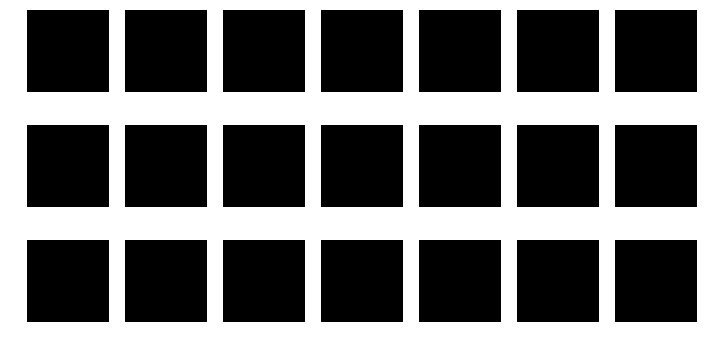

In [35]:
plt.rcParams['figure.figsize'] = 12,6
rows, cols = 3,7

for row in range(rows):
    
    for col in range(cols):
        
        i = col + row*cols
        
        plt.subplot(rows,cols,i+1)
        plt.imshow(non_images[np.random.randint(0,len(non_images))])
        plt.axis('off')

plt.show()

These are effectively just empty images. The reason they were included was probably due to the fact that before hard-limiting the shape, the last might've had at least a single valid pixel of data.

### 5.2 Yellow Blocks - Resolved

> Resolved by altering the code responsible for discarding the Alpha-band.

Second interesting RGB images are the yellowish ones. Let's drill down to the level of corresponding Block and date of the images.

*Re-running these snippets will lose the information.*

In [137]:
dp = DataPeriod.get(DataPeriod.id == 124052)
print("Block",dp.area.block_id,", date",dp.date.date())

Block 6090347888 , date 2017-06-22


Because the images are yellowish, there is a suspicion that the bands are somewhat wrong. Let's inspect a single DataPeriod's bands.

In [145]:
arr = pickle.loads(dp.area_drone_rgb)
means = np.mean(np.mean(arr,axis=0),axis=0)
print("Means R={}, G={}, B={}".format(means[0],means[1],means[2]))

Means R=0.5184934269636869, G=0.5197955116309458, B=0.0


We are indeed missing the Blue band. This requires further inspections. The code responsible for the reshaping and pickling the RGB-images is documented in the following way:

    For RGB rasters only the first three bands (red, green, blue) are persisted. The rasters are initially in the shape of (bands,x,y), i.e. 4x32x32 corresponging to RGBA channels (A is for alpha). The imaging libraries are able to show the images when the band information is present pixel wise, wherefore the arrays are reshaped to (x,y,bands).
    
The code snippet corresponding to this operation is as follows:
    
    reshaped = np.zeros((32, 32, 3))
    for i in range(area_raster.shape[0] - 1):
        for j in range(area_raster.shape[1]):
            for k in range(area_raster.shape[2]):
                reshaped[j, k, i] = area_raster[i, j, k]
                                
Thus we must first address the viability of the initial band ordering with this Block. The initial suspicion is on the Block's RGB-image, as the other Blocks rendered all three bands as correct-looking RGB images.

In [159]:
raster = gdal.Open(os.path.join(settings.BLOCK_DATA_DIR,'6090347888','20170628_drone_rgb.tif'))
arr = raster.ReadAsArray()
print("The image has {} bands with shape {} x {}".format(arr.shape[0],arr.shape[1],arr.shape[2]))

The image has 3 bands with shape 1469 x 1163


As suspected, the source image is missing the fourth band for alpha present in other images. We cannot easily perform the correction by inserting updates to corresponging DataPeriods. This will require building the dataset with a safety check for whether the image has a band for alpha or not. Here we'll however test if the algorithm performs as it is meant to.

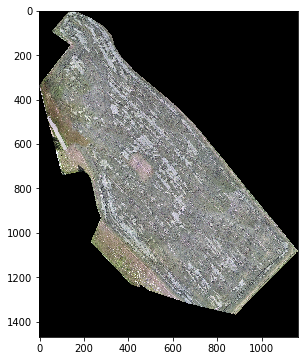

In [170]:
reshaped = np.zeros((arr.shape[1], arr.shape[2], 3))
for i in range(arr.shape[0]):
    for j in range(arr.shape[1]):
        for k in range(arr.shape[2]):
            reshaped[j, k, i] = arr[i, j, k]
plt.rcParams['figure.figsize'] = 8,6
plt.imshow(reshaped)
plt.show()

It does. Great!

### 5.3 Purple blocks - No action

> Nothing to do, as the problem lies in data collection and preparation steps.

After resolving the yellow-block problem and rebuild of the database, there was still an anomaly present. It was in the form of darker purplish tint, which is distinctly noticeable. Let's drill down to this.

In [29]:
dp = DataPeriod.get(DataPeriod.id == 43938)
print("Block",dp.area.block_id,", date",dp.date.date())

Block 6090324751 , date 2017-06-08


Means R=157.3935546875, G=152.4365234375, B=127.111328125


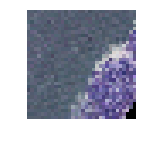

In [36]:
arr = pickle.loads(dp.area_drone_rgb)
means = np.mean(np.mean(arr,axis=0),axis=0)
print("Means R={}, G={}, B={}".format(means[0],means[1],means[2]))

plt.rcParams['figure.figsize'] = 3,2
plt.imshow(arr)
plt.axis('off')
plt.show()

First thing apparent is that the band values are not scaled. At least there is no band apparently missing. However there is a suspicion that the bands might be in wrong order. The plethora of proper images provide a good benchmark for visual comparison. We will therefore arrempt at visualizing the images by rearranging the bands. If we presume the initial bands to be RGB, we will produce the following band mixes: RGB, RBG, BRG, BGR, GBR and GRB.

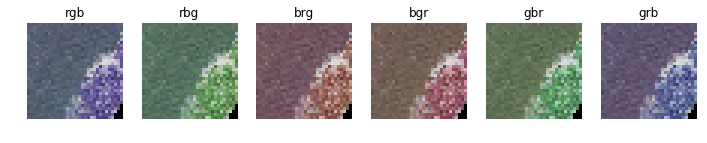

In [44]:
rgb = arr
rbg = np.zeros((32,32,3))
brg = np.zeros((32,32,3))
bgr = np.zeros((32,32,3))
gbr = np.zeros((32,32,3))
grb = np.zeros((32,32,3))

for row in range(rgb.shape[0]):
    
    for col in range(rgb.shape[1]):
        
        r, g, b = rgb[row][col]
        rbg[row][col] = [r, b, g]
        brg[row][col] = [b, r, g]
        bgr[row][col] = [b, g, r]
        gbr[row][col] = [g, b, r]
        grb[row][col] = [g, r, b]

plt.rcParams['figure.figsize'] = 12,3
titles = ['rgb','rbg','brg','bgr','gbr','grb']
for i, image in enumerate([rgb,rbg,brg,bgr,gbr,grb]):
    
    plt.subplot(1,6,i+1)
    plt.imshow(image)
    plt.title(titles[i])
    plt.axis('off')
    
plt.show()

Indeed the initial ordering of the bands seems to be off. If the Block would have greenery growing, the closer-to-correct ones are the RBG and GBR. We must however inspect the original image in QGIS for easier band swapping and a coherent overview. Let's also visualize the image here.

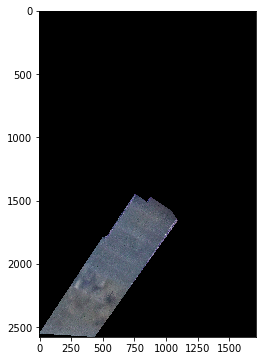

In [47]:
raster = gdal.Open(os.path.join(settings.BLOCK_DATA_DIR,'6090324751','20170609_drone_rgb.tif'))
arr = raster.ReadAsArray()
reshaped = np.zeros((arr.shape[1], arr.shape[2], 3))
for i in range(3):
    for j in range(arr.shape[1]):
        for k in range(arr.shape[2]):
            reshaped[j, k, i] = arr[i, j, k]
plt.rcParams['figure.figsize'] = 8,6
plt.imshow(reshaped)
plt.show()

The swapping proved to be unfruitful. The image of the DataPeriod is from the lower portion of the Block. During the shooting of the Block's image in question it had no greenery growing yet, so the wrong coloring seems to boil down to the preprocessing or even the image capture stage of the process. Thus we leave this one intact.

### 5.4 Drop of incorrect field - Resolved

It has come to our knowledge (10/2018) that one of our fields had its target values derived from yields of the year 2016. This is wrong and all occurences pointing to this field have to be dropped. The ``block_id`` of the field is ``6090345969``.

In [1]:
import os
from field_analysis.db.models import Area, DataPeriod, Target, initialize_db
import field_analysis.settings.model as model_settings
db_32 = 'field_analysis_10m_32px.db'
db_64 = 'field_analysis_20m_64px.db'
db_128 = 'field_analysis_40m_128px.db'
dbs = [db_32, db_64, db_128]

In [9]:
initialize_db(os.path.join(model_settings.DATABASES_DIR,db_32))
areas = Area.select().where(Area.block_id==6090345969)
areas.count()

763

In [10]:
dataperiods = DataPeriod.select().join(Area).where(Area.block_id==6090345969)
dataperiods.count()

12208

In [11]:
targets = Target.select().join(Area).where(Area.block_id==6090345969)
targets.count()

763

We have to remove occurences of this field from every database.

In [12]:
for db in dbs:
    print(db)
    initialize_db(os.path.join(model_settings.DATABASES_DIR,db))
    for dataperiod in DataPeriod.select().join(Area).where(Area.block_id==6090345969):
        dataperiod.delete_instance()
    for target in Target.select().join(Area).where(Area.block_id==6090345969):
        target.delete_instance()
    for area in Area.select().where(Area.block_id==6090345969):
        area.delete_instance()

field_analysis_10m_32px.db
field_analysis_20m_64px.db
field_analysis_40m_128px.db


Let's then review if there are any records left.

In [2]:
for db in dbs:
    print(db)
    initialize_db(os.path.join(model_settings.DATABASES_DIR,db))
    areas = Area.select().where(Area.block_id==6090345969)
    print(f'  Areas: {areas.count()}')
    dataperiods = DataPeriod.select().join(Area).where(Area.block_id==6090345969)
    print(f'  DataPeriods: {dataperiods.count()}')
    targets = Target.select().join(Area).where(Area.block_id==6090345969)
    print(f'  Targets: {targets.count()}')

field_analysis_10m_32px.db
  Areas: 0
  DataPeriods: 0
  Targets: 0
field_analysis_20m_64px.db
  Areas: 0
  DataPeriods: 0
  Targets: 0
field_analysis_40m_128px.db
  Areas: 0
  DataPeriods: 0
  Targets: 0
